# EDSA 2022 Classification Hackathon

### South African Language Identification

© Explore Data Science Academy (Accelerator)


# Introduction

South Africa is a multicultural society that is characterised by its rich linguistic diversity, with eleven(11) official languages. Most South Africans are multilingual and able to speak at least two or more of the official languages.

As systems and devices in South-Africa communicate in these multi-languages, in this challenge, we will take text which is in any of South Africa's 11 Official languages and identify which language the text is in.



In [2]:
!pip install xgboost

In [1]:
#Importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [13]:
#Importing the datasets
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

#Viewing a slice of the datframe
print("First 5 rows of the train data")
display(test_df.tail())

print("\n\n")

print('First 5 rows of the test data')
display(test_df.tail())

First 5 rows of the train data


,index,text
5677,5678,You mark your ballot in private.
5678,5679,Ge o ka kgetha ka bowena go se šomiše Mofani k...
5679,5680,"E Ka kopo etsa kgetho ya hao ka hloko, hobane ..."
5680,5681,"TB ke bokudi ba PMB, mme Morero o tla lefella ..."
5681,5682,Vakatjhela iwebhusayidi yethu ku-www.





First 5 rows of the test data


,index,text
5677,5678,You mark your ballot in private.
5678,5679,Ge o ka kgetha ka bowena go se šomiše Mofani k...
5679,5680,"E Ka kopo etsa kgetho ya hao ka hloko, hobane ..."
5680,5681,"TB ke bokudi ba PMB, mme Morero o tla lefella ..."
5681,5682,Vakatjhela iwebhusayidi yethu ku-www.


In [3]:
#Info and Description on dataset
print("\n\n", train_df.info(), "\n\n")
print(train_df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


 None 


         count unique                                                top  freq
lang_id  33000     11                                                xho  3000
text     33000  29948  ngokwesekhtjheni yomthetho ophathelene nalokhu...    17


In [4]:
count = train_df.groupby("lang_id").count()["text"].reset_index().sort_values(by="lang_id", ascending=True)
display(count.style.background_gradient(cmap="Blues"))

,lang_id,text
0,afr,3000
1,eng,3000
2,nbl,3000
3,nso,3000
4,sot,3000
5,ssw,3000
6,tsn,3000
7,tso,3000
8,ven,3000
9,xho,3000


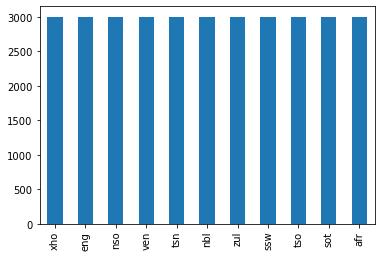

In [5]:
train_df['lang_id'].value_counts().plot(kind = 'bar')
plt.show()

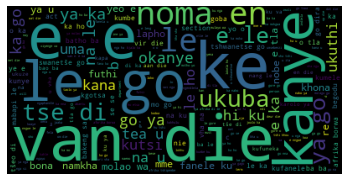

In [6]:
#Display the most recurrent words across all observations in a wordcloud image
full_text = " ".join(train_df['text'])

wc = WordCloud(background_color='black')
img = wc.generate(full_text)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
#Check out sections in the text lenght for each observation to determine what cleaning needs to be done.
for text in train_df['text'][50:60]:
    print(text)

prof frikkie van niekerk mokaedi wa setheo sa merero ya badiri baithuti boitshimololedi le dipatlisiso o ne a bolelela herce-vigil ka ga hisetori ya yunibesithi gammogo le photefolio ya yona ya ditshwanelo tsa botlhalefi
layisense yi va yi nyikiwile naswona xitifiketi xa layisense xi va xi nyikiwa eka munhu ku ya hi xiyenge lexi a yi hundziseriwi eka unwana munhu hlengeleta hinkwaswo swiviko eka probiti ya rixaka yo tsarisa leyi nga hlamuseriwa ndlela ya kahle na xivumbeko
loko kwesaba nekungavikeleki kwenta kutsi kube neminyaka yekuphikisa kuloku sibonga lichawe lakitsi lelaba nesibindzi solomon kalushi mahlangu lowatiphanyeka eminyakeni lengu- leyengca inhloko yakhe ibheke etulu ngelwati lwekutigcabha kutsi ingati yakhe itawutselisa sihlahla senkhululeko
taal geletterdheid en kommunikasie wiskundige geletterdheid wiskunde en die wiskundige wetenskappe die kunste en kultuur lewensoriëntering die mens- en sosiale wetenskappe die ekonomiese en bestuurswetenskappe die natuurwetenskappe t

##### The texts seem clean enough for tokenization and vectorization in preparation for modelling

In [8]:
#Creating a worked dataframe from the train data that can be concatenated with the train data
# test_df1 = test_df.drop('index', axis=1, inplace=False)

# #Concatenate both datasets to one for once-through processing/cleaning
# df = pd.concat([train_df, test_df1])
# df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [14]:
punc_numbers = string.punctuation + '0123456789'

def remove_punctuation(post):
  """This function returns a string item that has no punctuation marks and numbers."""
  punc_numbers = string.punctuation + '0123456789'
  return ''.join([l for l in post if l not in punc_numbers])

In [15]:
#removing punctuation in train data
train_df['new'] = train_df['text'].apply(remove_punctuation)
test_df['new'] = test_df['text'].apply(remove_punctuation)

In [16]:
#tokenizing
tokenizer = TreebankWordTokenizer()

#tokenizing train data  ''.join([l for l in post if l not in punc_numbers])
train_df['new'] = train_df['new'].apply(tokenizer.tokenize)
test_df['new'] =   test_df['new'].apply(tokenizer.tokenize)

In [17]:
def convert_to_string(text):
    return ' '.join(text)

train_df['new'] = train_df['new'].apply(convert_to_string)
test_df['new'] = test_df['new'].apply(convert_to_string)

In [18]:
train_df.tail()

,lang_id,text,new
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...,mafapha a mang le ona a lokela ho etsa ditlale...


In [19]:
#Vectorizing
vector = TfidfVectorizer(min_df=5)

#Vectorizing train data
train_tfidf = vector.fit_transform(train_df.new)

In [20]:
test_tfidf = vector.transform(test_df.new)

In [21]:
display(train_tfidf.shape)
display(test_tfidf.shape)

(33000, 24333)

(5682, 24333)

In [24]:
# #Transform vectorized train data to a dataframe
# vectorized_train_df = pd.DataFrame(train_tfidf, columns=vector.get_feature_names_out())

# #Transform vectorized test data to a dataframe
# vectorized_test_df = pd.DataFrame(test_tfidf, columns=vector.get_feature_names_out())

In [25]:
# vectorized_train_df.head()

In [26]:
#Training dataset
train_feat = train_tfidf
train_target = train_df['lang_id']

#Test dataset
test_features =  test_tfidf

In [27]:
X_train, X_test, y_train, y_test =train_test_split(train_feat, 
                                                   train_target, 
                                                   test_size=0.3, 
                                                   random_state=50)

In [28]:
# Set up selector, choosing score function and number of features to retain
selector = SelectKBest(score_func=f_classif, k=4000)

# Transform (i.e.: run selection on) the training data
fit = selector.fit(X_train, y_train)

#Selecting the Best 4000 features from the train dataset
X_train_kbest = X_train[X_train.columns[selector.get_support(indices=True)]]
X_test_kbest = X_test[X_test.columns[selector.get_support(indices=True)]]

C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 0 0 0 0 0 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\User\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


AttributeError: columns not found

In [ ]:
select_columns = X_test_kbest.columns
cols = list(select_columns)

#Selecting the Best 4000 features from the test dataset
test_features_kbest = test_features[cols]

In [29]:
# Here 'ovr' indicates that we have selected our One-vs-Rest strategy. 
logreg = LogisticRegression(multi_class='ovr', random_state=50)

#Fitting
logreg.fit(X_train, y_train)

# Generate predictions
y_pred_test = logreg.predict(X_test)

In [30]:
y_pred_test

array(['afr', 'tsn', 'nso', ..., 'sot', 'nbl', 'afr'], dtype=object)

In [31]:
f1_score = metrics.f1_score(y_test, y_pred_test, average='macro')
f1_score

0.9954248410822008

In [ ]:
y_pred_test

In [32]:
# Generate predictions from test data
y_pred_test_df = logreg.predict(test_features)
y_pred_test_df

array(['tsn', 'nbl', 'ven', ..., 'sot', 'sot', 'zul'], dtype=object)

In [33]:
#Creating a submission

submission_df = pd.DataFrame({"index": test_df['index'],
    "lang_id": y_pred_test_df})
submission_df.to_csv('1stsubmission.csv', index=False)

In [ ]:
sub_temp = pd.read_csv('1stsubmission.csv')
sub_temp

In [41]:
# Here 'ovr' indicates that we have selected our One-vs-Rest strategy. 
from sklearn.naive_bayes import MultinomialNB
GNC = MultinomialNB()

#Fitting
GNC.fit(X_train, y_train)

# Generate predictions
y_pred_2 = logreg.predict(X_test)# Here 'ovr' indicates that we have selected our One-vs-Rest strategy. 



In [43]:
# Generate predictions from test data
y_pred_test_df2 = GNC.predict(test_features)
y_pred_test_df2

array(['tsn', 'nbl', 'ven', ..., 'sot', 'sot', 'zul'], dtype='<U3')

In [ ]:
submission_df2 = pd.DataFrame({"index": test_df['index'],
    "lang_id": y_pred_test_df2})
submission_df2.to_csv('2ndsubmission.csv', index=False)

In [ ]:
names = ['LogisticRegression', 'DTClassifier', 'ForestClassifier', 'XGBClassifier', 'NBClassifier', 'NNClassifier', 'SVMClassifier'
        'KNNClassifier']

In [ ]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    GaussianNB(),
    MLPClassifier(),
    SVC(),
    KNeighborsClassifier()
]

In [ ]:
model = SVC(kernel='rbf')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('SVC with Hyperparameter kernel= rbf')
print('f1 score',f1_score(y_test, y_pred,average="macro"))
print('accuracy_score',accuracy_score(y_test, y_pred))

In [ ]:
results = []

models= {}
confusion= {}
class_report= {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(x_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(x_train)   
    y_pred_test = clf.predict(x_valid)
    
    print ('... scoring')
    accuracy  = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred,average="macro")
    recall    = recall_score(y_train, y_pred,average="macro")
    
    f1        = f1_score(y_train, y_pred,average="macro")    
    f1_test   = f1_score(y_valid, y_pred_test,average="macro")    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = confusion_matrix(y_train, y_pred)
    class_report[name] = classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

In [118]:
results = []
models = {}
for name, clf in zip(names, classifiers):
    print('Fitting {:s} model.....'.format(name))
    # We train each model using .fit
    clf.fit(X_train_kbest, y_train)
    
    #Carry out prediction on X_train
    print('..... Predicting')
    y_pred_train = clf.predict(X_train_kbest)
    
    #Carry out prediction on X_test
    print('..... Predicting')
    y_pred_test = clf.predict(X_test_kbest)
    
    #Score the models with the accuracy and F1_score.
    print('..... Scoring')
    accuracy = metrics.accuracy_score(y_train, y_pred_train) # Test Accuracy
    f1_Score = f1_score(y_train, y_pred_train, average='macro')
    f1_Score1 = f1_score(y_test, y_pred_test, average='macro')
    
    #Save the results to dictionaries
    models[name] = clf
    
    results.append([name, accuracy, f1_Score, f1_Score1])
    
#Creating a df from the results    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy Score', 'F1 Train', 'F1 Test'])
results.set_index('Classifier', inplace=True)

Fitting LogisticRegression model.....


C:\Users\Engr  Dasilva\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


..... Predicting
..... Predicting
..... Scoring


TypeError: 'numpy.float64' object is not callable